# **Code for model training**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings('ignore')
import os

Data connection

In [ ]:
TRAIN = os.listdir(r"C:\Users\mariy\Desktop\test\train_v2")
TEST = os.listdir(r"C:\Users\mariy\Desktop\test\test_v2")
TRAIN_DIR = r"C:\Users\mariy\Desktop\test\train_v2"
TEST_DIR = r"C:\Users\mariy\Desktop\test\test_v2"
df = pd.read_csv(r"C:\Users\mariy\Desktop\test\train_ship_segmentations_v2.csv\train_ship_segmentations_v2.csv")
df_sub = pd.read_csv(r"C:\Users\mariy\Desktop\test\sample_submission_v2.csv")

Constants

In [ ]:
IMG_WIDTH = 768
IMG_HEIGHT = 768
IMG_CHANNELS = 3
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
epochs=10
batch_size=32
image_shape=(768, 768)
FAST_RUN=True # use for development only
FAST_PREDICTION=True # use for development only

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
no_mask = np.zeros(image_shape[0]*image_shape[1], dtype=np.uint8)
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def rle_decode(mask_rle, shape=image_shape):
    '''
        mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    if pd.isnull(mask_rle):
        img = no_mask
        return img.reshape(shape).T
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

In [ ]:
# Model interface
inputs = Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

# 128

down1 = Conv2D(64, (3, 3), padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(64, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
# 64

down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2 = Conv2D(128, (3, 3), padding='same')(down2)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
# 32
down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3 = Conv2D(256, (3, 3), padding='same')(down3)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
# 16

down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4 = Conv2D(512, (3, 3), padding='same')(down4)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
# 8
center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(1024, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)
# center

up4 = UpSampling2D((2, 2))(center)
up4 = concatenate([down4, up4], axis=3)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
# 16
up3 = UpSampling2D((2, 2))(up4)
up3 = concatenate([down3, up3], axis=3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
# 32

up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down2, up2], axis=3)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
# 64
up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
# 128

outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(1e-4)

In [ ]:
model.compile(
    optimizer=optimizer, 
    loss="binary_crossentropy", 
    metrics=[dice_coef]
)

In [ ]:
# use for development to run it faster
if FAST_RUN:
    df = df.sample(n=1000).reset_index().drop(columns=["index"]) # after reset index dataframe will have one more column call index
    
if FAST_PREDICTION:
    df_sub = df_sub.sample(n=100).reset_index().drop(columns=["index"]) # after reset index dataframe will have one more 

Split data

In [ ]:
train_df, validate_df = train_test_split(df,
                                        test_size=.2,
                                        random_state=2022)

In [ ]:
def get_image(image_name):
    img = imread(r"C:\Users\mariy\Desktop\test\train_v2\\"+image_name)[:,:,:IMG_CHANNELS]
    img = resize(img, (TARGET_WIDTH, TARGET_HEIGHT), mode='constant', preserve_range=True)
    return img
    
def get_mask(code):
    img = rle_decode(code)
    img = resize(img, (TARGET_WIDTH, TARGET_HEIGHT, 1), mode='constant', preserve_range=True)
    return img

In [ ]:
def create_image_generator(precess_batch_size, data_df):
    while True:
        for k, group_df in data_df.groupby(np.arange(data_df.shape[0])//precess_batch_size):
            imgs = []
            labels = []
            for index, row in group_df.iterrows():
                # images
                original_img = get_image(row.ImageId) / 255.0
                # masks
                mask = get_mask(row.EncodedPixels) / 255.0
                
                imgs.append(original_img)
                labels.append(mask)
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels

In [ ]:
train_generator = create_image_generator(batch_size, train_df)
validate_generator = create_image_generator(batch_size, validate_df)

Train model

In [ ]:
# Save best model at every epoch
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [ ]:
# fit model
train_steps=np.ceil(float(train_df.shape[0]) / float(batch_size)).astype(int)
validate_steps=np.ceil(float(validate_df.shape[0]) / float(batch_size)).astype(int)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_steps,
    validation_data=validate_generator,
    callbacks=[checkpoint],
    validation_steps=validate_steps,
    epochs=epochs
)

Epoch 1/10
25/25 [==============================] - 729s 29s/step - loss: 0.3519 - dice_coef: 0.9207 - val_loss: 0.6599 - val_dice_coef: 0.8108
Epoch 2/10
25/25 [==============================] - 712s 29s/step - loss: 0.1682 - dice_coef: 0.9763 - val_loss: 0.5609 - val_dice_coef: 0.8444
Epoch 3/10
25/25 [==============================] - 725s 29s/step - loss: 0.1355 - dice_coef: 0.9841 - val_loss: 0.4404 - val_dice_coef: 0.8874
Epoch 4/10
25/25 [==============================] - 739s 30s/step - loss: 0.1212 - dice_coef: 0.9871 - val_loss: 0.3225 - val_dice_coef: 0.9293
Epoch 5/10
25/25 [==============================] - 754s 30s/step - loss: 0.1092 - dice_coef: 0.9894 - val_loss: 0.2349 - val_dice_coef: 0.9579
Epoch 6/10
25/25 [==============================] - 768s 31s/step - loss: 0.0977 - dice_coef: 0.9914 - val_loss: 0.1731 - val_dice_coef: 0.9751
Epoch 7/10
25/25 [==============================] - 782s 31s/step - loss: 0.0886 - dice_coef: 0.9928 - val_loss: 0.1348 - val_dice_coef:

In [ ]:
def get_test_image(image_name):
    img = imread(r"C:\Users\mariy\Desktop\test\test_v2\\"+image_name)[:,:,:IMG_CHANNELS]
    img = resize(img, (TARGET_WIDTH, TARGET_HEIGHT), mode='constant', preserve_range=True)
    return img
    
def create_test_generator(precess_batch_size):
    while True:
        for k, ix in df_sub.groupby(np.arange(df_sub.shape[0])//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                original_img = get_test_image(row.ImageId) / 255.0
                imgs.append(original_img)
                
            imgs = np.array(imgs)
            yield imgs

In [ ]:
test_generator = create_test_generator(batch_size)

Make Predictions

In [ ]:
test_steps = np.ceil(float(df_sub.shape[0]) / float(batch_size)).astype(int)
predict_mask = model.predict_generator(test_generator, steps=test_steps)

In [ ]:
type(predict_mask)

numpy.ndarray

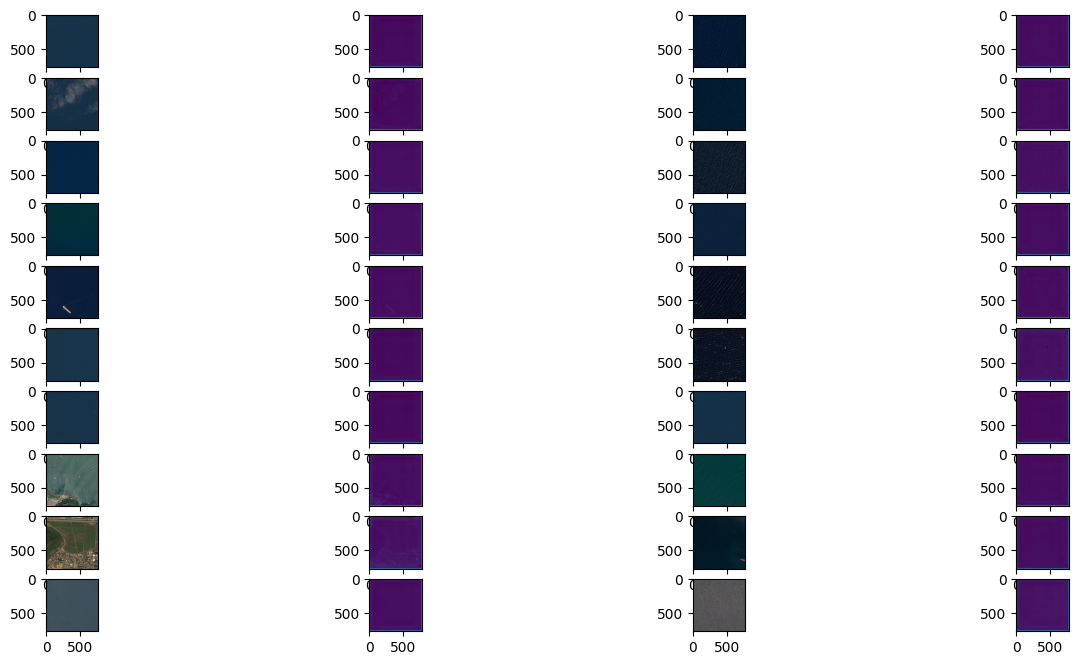

In [ ]:
fig=plt.figure(figsize=(16, 8))
for index, row in df_sub.head(20).iterrows():
    origin_image = imread(r"C:\Users\mariy\Desktop\test\test_v2\\"+row.ImageId)
    predicted_image = resize(predict_mask[index], image_shape).reshape(IMG_WIDTH, IMG_HEIGHT) * 255
    plt.subplot(10, 4, 2*index+1)
    plt.imshow(origin_image)
    plt.subplot(10, 4, 2*index+2)
    plt.imshow(predicted_image)

In [ ]:
predict_mask.shape

(100, 128, 128, 1)

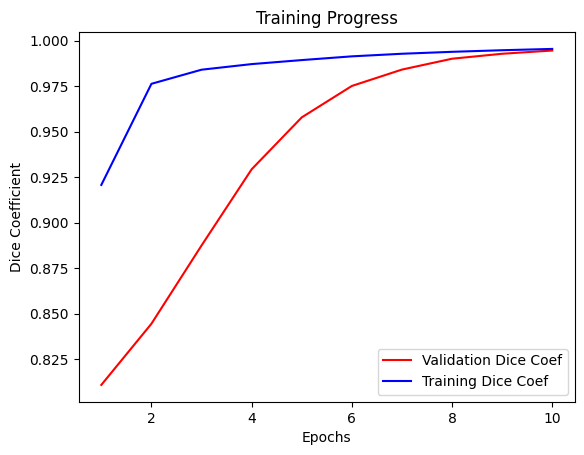

In [ ]:
# Plot training progress
epochs = range(1, len(history.history['val_dice_coef']) + 1)
plt.plot(epochs, history.history['val_dice_coef'], 'r', label='Validation Dice Coef')
plt.plot(epochs, history.history['dice_coef'], 'b', label='Training Dice Coef')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()